In [82]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
import lightgbm as lgb
import xgboost as xgb

# Import Data

In [83]:
#Read raw data
properties_2016 = pd.read_csv('properties_2016.csv', dtype={
        'propertycountylandusecode': str,
        'hashottuborspa': str,
        'propertyzoningdesc': str,
        'fireplaceflag': str,
        'taxdelinquencyflag': str})
    
properties_2017 = pd.read_csv('properties_2017.csv', dtype={
        'propertycountylandusecode': str,
        'hashottuborspa': str,
        'propertyzoningdesc': str,
        'fireplaceflag': str,
        'taxdelinquencyflag': str})

train_2016 = pd.read_csv('train_2016_v2.csv',  parse_dates=['transactiondate'])
train_2017 = pd.read_csv('train_2017.csv',  parse_dates=['transactiondate'])

sample = pd.read_csv('sample_submission.csv')    #For prediction
sample['parcelid'] = sample['ParcelId']          

# Data Preprocessing

In [84]:
#Merge 2016 & 2017 training data with properties

train_2016 = pd.merge(train_2016, properties_2016, how='left', on='parcelid')
train_2017 = pd.merge(train_2017, properties_2017, how='left', on='parcelid')
train_df = pd.concat([train_2016, train_2017], axis=0)
test_df = pd.merge(sample, properties_2016, how='left', on='parcelid')

del properties_2017, train_2016, train_2017
gc.collect();

print("Train: ", train_df.shape)
print("Test: ", test_df.shape)

Train:  (167888, 60)
Test:  (2985217, 65)


In [85]:
# Calculate missing percentage 
missing_ratio = train_df.isna().sum().sort_values(ascending = False)/len(train_df)
missing_ratio

#Remove columns with insufficient data
threshold = 0.98  
insufficient_col = []
rows = train_df.shape[0]

for x in train_df.columns:
    counter = train_df[x].isnull().sum()
    if counter == 0: 
        continue
    percentage = counter/rows
    if percentage > threshold: 
        insufficient_col.append(x)
len(insufficient_col)

13

In [86]:
#Remove variables with one unique value
unique_col = train_df.columns[train_df.nunique()==1]
len(unique_col)

9

In [87]:
#Remove unnecessary vairables  
remove_col = ['parcelid', 'logerror', 'propertyzoningdesc', 'propertycountylandusecode']

In [88]:
#Segregate dates
def format_dates(df):
    df["year"] = df["transactiondate"].dt.year.astype(int)
    df["month"] = df["transactiondate"].dt.month.astype(int)
    df["day"] = df["transactiondate"].dt.day.astype(int)
    df["quarter"] = df["transactiondate"].dt.quarter.astype(int)
    df.drop(["transactiondate"], inplace=True, axis=1)
    
    return df

train_df = format_dates(train_df)

In [89]:
#Remove outliers 
train_df=train_df[train_df.logerror > -0.4]
train_df=train_df[train_df.logerror < 0.42]

In [90]:
#training features
train_features = []
for x in train_df.columns:
    if x not in insufficient_col and x not in unique_col and x not in remove_col:
        train_features.append(x)

In [91]:
#Fill in blank values
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)

In [92]:
#split data 
x_train, x_test, y_train, y_test = train_test_split(train_df[train_features], train_df.logerror, test_size=0.2, random_state=99)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(131584, 42) (131584,)
(32897, 42) (32897,)


# CatBoost Model

In [93]:
#categorical_features 
cat_features = []
threshold = 5000
for x, c in enumerate(train_features):
    counter = len(train_df[c].unique())
    if counter < threshold \
       and not 'sqft' in c \
       and not 'cnt' in c \
       and not 'nbr' in c \
       and not 'number' in c:
        cat_features.append(x)
        
#print([train_features[x] for x in cat_features])

In [94]:
#Fitting catboost model
train_pool = Pool(x_train.astype(int), y_train, cat_features)
test_pool = Pool(x_test.astype(int), y_test, cat_features) 

In [95]:
#catboost model parameters
num_ensembles = 5
y_pred = 0.0

for i in tqdm(range(num_ensembles)):
    cat_model = CatBoostRegressor(
        iterations= 300, 
        learning_rate=0.04,
        depth=6, 
        l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=i)
    
    #train the model
    cat_model.fit(train_pool, eval_set=test_pool)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0:	learn: 0.0530376	test: 0.0528002	best: 0.0528002 (0)	total: 130ms	remaining: 38.8s
1:	learn: 0.0530169	test: 0.0527796	best: 0.0527796 (1)	total: 312ms	remaining: 46.5s
2:	learn: 0.0529978	test: 0.0527597	best: 0.0527597 (2)	total: 480ms	remaining: 47.5s
3:	learn: 0.0529783	test: 0.0527396	best: 0.0527396 (3)	total: 644ms	remaining: 47.6s
4:	learn: 0.0529604	test: 0.0527225	best: 0.0527225 (4)	total: 817ms	remaining: 48.2s
5:	learn: 0.0529429	test: 0.0527059	best: 0.0527059 (5)	total: 988ms	remaining: 48.4s
6:	learn: 0.0529274	test: 0.0526913	best: 0.0526913 (6)	total: 1.16s	remaining: 48.5s
7:	learn: 0.0529134	test: 0.0526772	best: 0.0526772 (7)	total: 1.31s	remaining: 47.8s
8:	learn: 0.0529014	test: 0.0526647	best: 0.0526647 (8)	total: 1.51s	remaining: 48.7s
9:	learn: 0.0528840	test: 0.0526483	best: 0.0526483 (9)	total: 1.68s	remaining: 48.7s
10:	learn: 0.0528698	test: 0.0526314	best: 0.0526314 (10)	total: 1.87s	remaining: 49.2s
11:	learn: 0.0528575	test: 0.0526182	best: 0.0526182

 20%|████████████████▊                                                                   | 1/5 [00:55<03:41, 55.30s/it]

0:	learn: 0.0530305	test: 0.0527961	best: 0.0527961 (0)	total: 178ms	remaining: 53.2s
1:	learn: 0.0530092	test: 0.0527743	best: 0.0527743 (1)	total: 367ms	remaining: 54.6s
2:	learn: 0.0529872	test: 0.0527524	best: 0.0527524 (2)	total: 540ms	remaining: 53.4s
3:	learn: 0.0529692	test: 0.0527343	best: 0.0527343 (3)	total: 725ms	remaining: 53.7s
4:	learn: 0.0529503	test: 0.0527148	best: 0.0527148 (4)	total: 921ms	remaining: 54.3s
5:	learn: 0.0529338	test: 0.0526984	best: 0.0526984 (5)	total: 1.11s	remaining: 54.5s
6:	learn: 0.0529143	test: 0.0526786	best: 0.0526786 (6)	total: 1.3s	remaining: 54.3s
7:	learn: 0.0528999	test: 0.0526651	best: 0.0526651 (7)	total: 1.46s	remaining: 53.3s
8:	learn: 0.0528863	test: 0.0526514	best: 0.0526514 (8)	total: 1.63s	remaining: 52.8s
9:	learn: 0.0528721	test: 0.0526369	best: 0.0526369 (9)	total: 1.82s	remaining: 52.9s
10:	learn: 0.0528577	test: 0.0526217	best: 0.0526217 (10)	total: 1.98s	remaining: 52.1s
11:	learn: 0.0528432	test: 0.0526075	best: 0.0526075 

 40%|█████████████████████████████████▌                                                  | 2/5 [01:54<02:49, 56.44s/it]

0:	learn: 0.0530308	test: 0.0527941	best: 0.0527941 (0)	total: 168ms	remaining: 50.1s
1:	learn: 0.0530097	test: 0.0527725	best: 0.0527725 (1)	total: 343ms	remaining: 51s
2:	learn: 0.0529874	test: 0.0527503	best: 0.0527503 (2)	total: 525ms	remaining: 52s
3:	learn: 0.0529698	test: 0.0527328	best: 0.0527328 (3)	total: 712ms	remaining: 52.7s
4:	learn: 0.0529522	test: 0.0527155	best: 0.0527155 (4)	total: 902ms	remaining: 53.2s
5:	learn: 0.0529341	test: 0.0526978	best: 0.0526978 (5)	total: 1.1s	remaining: 53.9s
6:	learn: 0.0529200	test: 0.0526831	best: 0.0526831 (6)	total: 1.26s	remaining: 52.9s
7:	learn: 0.0529066	test: 0.0526697	best: 0.0526697 (7)	total: 1.43s	remaining: 52.2s
8:	learn: 0.0528912	test: 0.0526553	best: 0.0526553 (8)	total: 1.59s	remaining: 51.3s
9:	learn: 0.0528785	test: 0.0526426	best: 0.0526426 (9)	total: 1.77s	remaining: 51.3s
10:	learn: 0.0528620	test: 0.0526274	best: 0.0526274 (10)	total: 1.95s	remaining: 51.2s
11:	learn: 0.0528489	test: 0.0526145	best: 0.0526145 (11)

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:52<01:54, 57.04s/it]

0:	learn: 0.0530302	test: 0.0527948	best: 0.0527948 (0)	total: 182ms	remaining: 54.5s
1:	learn: 0.0530057	test: 0.0527710	best: 0.0527710 (1)	total: 368ms	remaining: 54.8s
2:	learn: 0.0529852	test: 0.0527499	best: 0.0527499 (2)	total: 582ms	remaining: 57.6s
3:	learn: 0.0529685	test: 0.0527329	best: 0.0527329 (3)	total: 772ms	remaining: 57.2s
4:	learn: 0.0529523	test: 0.0527167	best: 0.0527167 (4)	total: 975ms	remaining: 57.5s
5:	learn: 0.0529365	test: 0.0526998	best: 0.0526998 (5)	total: 1.14s	remaining: 56.1s
6:	learn: 0.0529216	test: 0.0526844	best: 0.0526844 (6)	total: 1.3s	remaining: 54.4s
7:	learn: 0.0529046	test: 0.0526661	best: 0.0526661 (7)	total: 1.5s	remaining: 54.6s
8:	learn: 0.0528914	test: 0.0526524	best: 0.0526524 (8)	total: 1.71s	remaining: 55.2s
9:	learn: 0.0528784	test: 0.0526386	best: 0.0526386 (9)	total: 1.9s	remaining: 55.1s
10:	learn: 0.0528661	test: 0.0526258	best: 0.0526258 (10)	total: 2.08s	remaining: 54.7s
11:	learn: 0.0528509	test: 0.0526102	best: 0.0526102 (1

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:50<00:57, 57.13s/it]

0:	learn: 0.0530339	test: 0.0527971	best: 0.0527971 (0)	total: 205ms	remaining: 1m 1s
1:	learn: 0.0530120	test: 0.0527755	best: 0.0527755 (1)	total: 404ms	remaining: 1m
2:	learn: 0.0529924	test: 0.0527556	best: 0.0527556 (2)	total: 612ms	remaining: 1m
3:	learn: 0.0529713	test: 0.0527354	best: 0.0527354 (3)	total: 790ms	remaining: 58.4s
4:	learn: 0.0529531	test: 0.0527166	best: 0.0527166 (4)	total: 985ms	remaining: 58.1s
5:	learn: 0.0529381	test: 0.0527003	best: 0.0527003 (5)	total: 1.14s	remaining: 56s
6:	learn: 0.0529191	test: 0.0526809	best: 0.0526809 (6)	total: 1.33s	remaining: 55.5s
7:	learn: 0.0529035	test: 0.0526665	best: 0.0526665 (7)	total: 1.51s	remaining: 55.3s
8:	learn: 0.0528878	test: 0.0526515	best: 0.0526515 (8)	total: 1.69s	remaining: 54.5s
9:	learn: 0.0528755	test: 0.0526387	best: 0.0526387 (9)	total: 1.86s	remaining: 54s
10:	learn: 0.0528623	test: 0.0526246	best: 0.0526246 (10)	total: 2.05s	remaining: 54s
11:	learn: 0.0528523	test: 0.0526151	best: 0.0526151 (11)	total:

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:47<00:00, 57.48s/it]


In [96]:
feature_importance_df = cat_model.get_feature_importance(prettified=True)
feature_importance_df

,Feature Id,Importances
0,taxamount,8.807788
1,calculatedfinishedsquarefeet,8.032376
2,finishedsquarefeet12,7.892078
3,month,6.473150
4,regionidzip,6.410567
5,regionidcity,5.526806
6,propertylandusetypeid,5.306594
7,regionidneighborhood,4.342409
8,lotsizesquarefeet,3.824456
9,taxvaluedollarcnt,3.741069


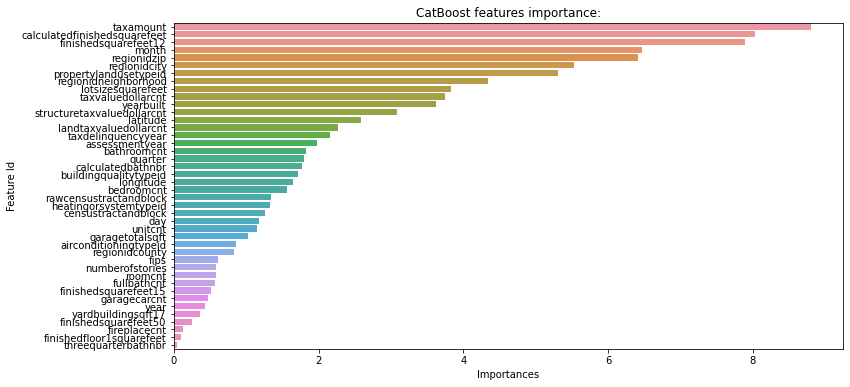

In [97]:
#Plot feature importance 
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost features importance:');

In [98]:
#interactive plot, can switch y-axis and x-axis to analyse data 
explainer = shap.TreeExplainer(cat_model) 
shap_values = explainer.shap_values(train_pool) 

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], x_train.iloc[:100,:])

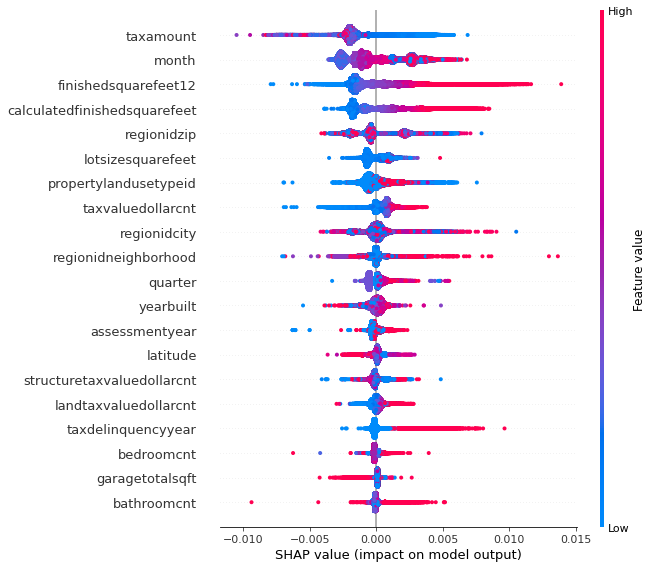

In [99]:
#summary plot 
shap.summary_plot(shap_values, x_train)

In [100]:
#Predict using catboost model
catboost_prediction = pd.DataFrame({'ParcelId':test_df['parcelid']})

test_dates = {
    '201610': pd.Timestamp('2016-09-30'),
    '201611': pd.Timestamp('2016-10-31'),
    '201612': pd.Timestamp('2016-11-30'),
    '201710': pd.Timestamp('2017-09-30'),
    '201711': pd.Timestamp('2017-10-31'),
    '201712': pd.Timestamp('2017-11-30')}

print("Predicting...")
for x, test_date in test_dates.items():
    test_df['transactiondate'] = test_date
    test_df = format_dates(test_df)
    log_error_pred = 0.0
    for i in range(num_ensembles):
        log_error_pred += cat_model.predict(test_df[train_features].astype(int))
    log_error_pred /= num_ensembles
    catboost_prediction[x] = log_error_pred
    
catboost_prediction.to_csv(
    'catboost_prediction.csv',
    float_format='%.5f',
    index=False)
print("Completed! catboost_prediction.csv is created.")

Predicting...
Completed! catboost_prediction.csv is created.


# LightGBM

In [101]:
#Fitting lgb model
train_lgb = lgb.Dataset(x_train, label=y_train)
test_lgb = lgb.Dataset(x_test, label=y_test)

In [102]:
#lgm model parameters
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 500
params['min_hessian'] = 1
params['max_depth'] = 8

In [103]:
#train model 
lgb_model = lgb.train(params, train_lgb, 500, test_lgb)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5154
[LightGBM] [Info] Number of data points in the train set: 131584, number of used features: 42
[LightGBM] [Info] Start training from score 0.008201
[1]	valid_0's l1: 0.0528606
[2]	valid_0's l1: 0.0528583
[3]	valid_0's l1: 0.052856
[4]	valid_0's l1: 0.0528538
[5]	valid_0's l1: 0.0528511
[6]	valid_0's l1: 0.0528483
[7]	valid_0's l1: 0.0528458
[8]	valid_0's l1: 0.0528434
[9]	valid_0's l1: 0.0528415
[10]	valid_0's l1: 0.0528395
[11]	valid_0's l1: 0.0528368
[12]	valid_0's l1: 0.0528351
[13]	valid_0's l1: 0.0528331
[14]	valid_0's l1: 0.0528313
[15]	valid_0's l1: 0.0528286
[16]	valid_0's l1: 0.0528262
[17]	valid_0's l1: 0.0528242
[18]	valid_0's l1: 0.0528217
[19]	valid_0's l1: 0.0528196
[20]	valid_0's l1: 0.052817
[21]	valid_0's l1: 0.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

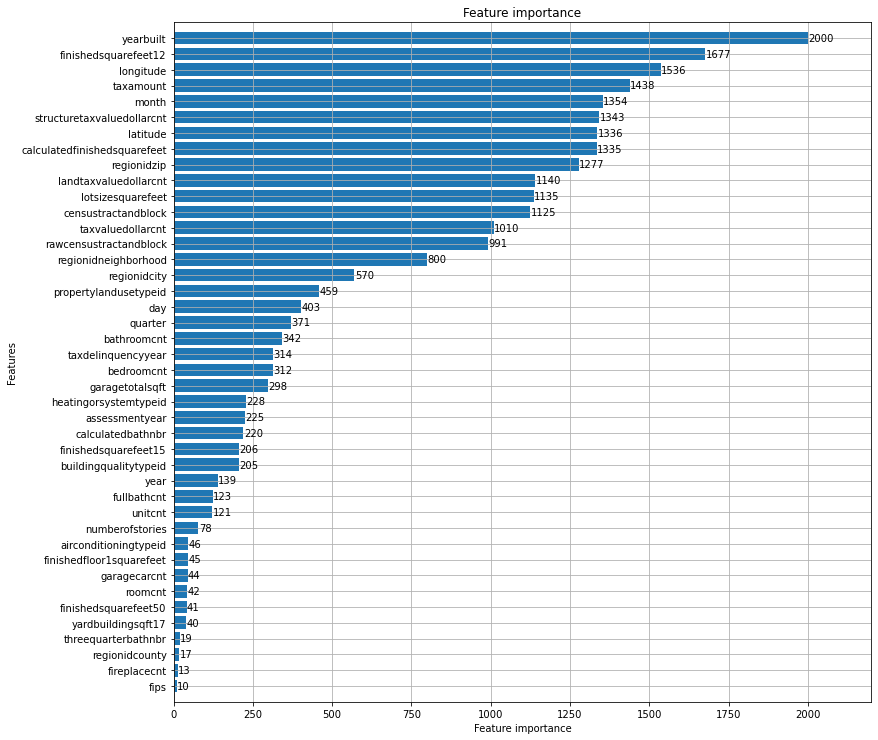

In [104]:
#Plot feature importance 
lgb.plot_importance(lgb_model, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [105]:
#Predict using lightGBM 
test_df = pd.merge(sample, properties_2016, how='left', on='parcelid')
test_df.fillna(-999, inplace=True)

lgb_prediction = pd.DataFrame({'ParcelId':test_df['parcelid']})

test_dates = {
    '201610': pd.Timestamp('2016-09-30'),
    '201611': pd.Timestamp('2016-10-31'),
    '201612': pd.Timestamp('2016-11-30'),
    '201710': pd.Timestamp('2017-09-30'),
    '201711': pd.Timestamp('2017-10-31'),
    '201712': pd.Timestamp('2017-11-30')}


print("Predicting...")
for x, test_date in test_dates.items():
    test_df['transactiondate'] = test_date
    test_df = format_dates(test_df)
    test_df = test_df[train_features]
    lgb_prediction[x] = lgb_model.predict(test_df)
    
lgb_prediction.to_csv(
    'lgb_prediction.csv',
    float_format='%.5f',
    index=False)
print("Completed! lgb_rediction.csv is created.")

Predicting...
Completed! lgb_rediction.csv is created.


# XGBoost Model

In [106]:
#Fitting xgboost model
train_xgboost = xgb.DMatrix(x_train, y_train)
test_xgboost = xgb.DMatrix(x_test, y_test)

In [107]:
#xgboost model parameters
xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': np.mean(y_train),
}

In [108]:
#train model 
num_boost_rounds = 500
xgb_model = xgb.train(dict(xgb_params), train_xgboost, num_boost_round=num_boost_rounds)

[14:58:20] WARNING: d:\bld\xgboost-split_1615294821523\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

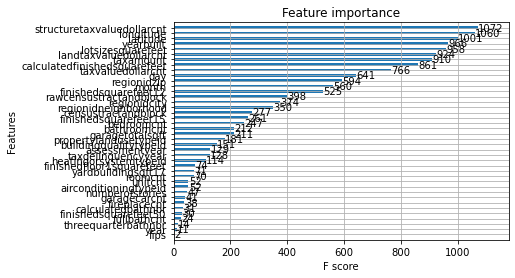

In [109]:
#Plot feature importance 
xgb.plot_importance(xgb_model, height=0.5)

In [110]:
#Predict using xgboost model
test_df = pd.merge(sample, properties_2016, how='left', on='parcelid')
test_df.fillna(-999, inplace=True)

d_test = xgb.DMatrix(test,enable_categorical=True)

print("Predicting...")
xgb_prediction = xgb_model.predict(d_test)
test_df['201610'] = xgb_prediction
test_df['201611'] = xgb_prediction
test_df['201612'] = xgb_prediction
test_df['201710'] = xgb_prediction
test_df['201711'] = xgb_prediction
test_df['201712'] = xgb_prediction

test_df = test_df[['ParcelId', '201610', '201611', '201612', '201710', '201711', '201712']]
test_df.to_csv(
    'xgb_prediction.csv',
    float_format='%.5f',
    index=False)
print("Completed! xgb_prediction.csv is created.")

Predicting...
Completed! xgb_prediction.csv is created.
